In [1]:
%pwd
%cd ../

/Users/annubaka/Library/Mobile Documents/com~apple~CloudDocs/Projects/Python/Personal/SNARE


/Users/annubaka/Library/Mobile Documents/com~apple~CloudDocs/Projects/Python/Personal/SNARE/.venv/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from db.database_setup import ListingsDatabase

pd.set_option('display.max_colwidth', 50)
pd.set_option('display.max_columns', None)



The problem in question: 
Innocent renters are routinely misled by fraudulent apartment listings. This results in financial loss, wasted time, and eroded trust in rental platforms. We want to detect these listings before users interact with them.

Why is this an issue:
Fake listings can cost a user $500–$2000 in deposits, cause major relocation delays, and damage the credibility of rental platforms like Craigslist or Facebook Marketplace.

Because ground truth labels are rarely available, most scams are only identified after the fact, if at all. So, we treat this as an unsupervised anomaly detection problem.

We hypothesize that fraudulent listings deviate from legitimate ones in terms of price, language, location patterns, and posting frequency. Our goal is to surface statistically significant outliers that exhibit these deviations.

We aim to explore which dimensions (e.g. price per square foot, language style, closeness to vulnerable locations) contribute most strongly to listings being flagged as anomalies.

What behavioral or structural patterns recur across flagged anomalies? Are there repeat tactics that align with known scam indicators?

Goal:
Develop an unsupervised anomaly detection system that flags suspicious apartment listings based on price anomalies, language cues, metadata inconsistencies, and location density deviations.

Why it matters:
Early detection reduces scam exposure, protects users, and enhances platform trust. The ability to flag potential scams can also assist human moderators or serve as a triage layer.

## clean and prepare the data

In [3]:
# load the dataset from the database
db = ListingsDatabase("data/listings.db")
listings = db.get_listings(source="craigslist")

df = pd.DataFrame(listings)
df = df.drop(['id', 'created_at', 'updated_at'], axis=1, errors='ignore')

print(f"Loaded {len(df)} listings")
df.head(3)

✓ Database initialized successfully
Loaded 2115 listings


,listing_id,source,listing_name,price,address,city,state,postal_code,latitude,longitude,bedrooms,bathrooms,square_footage,time_posted,description,phone_number,url
0,7854062085,craigslist,REDUCED PRICING! 3 Bedroom 2 Bathroom Apartmen...,1950.0,9000 Colby Drive,Fort Myers,FL,33919,26.556700,-81.903400,3.0,2.0,1330.0,2025-05-29 13:01:10-04:00,QR Code Link to This Post\n\n\nResidential Com...,7854062085,https://fortmyers.craigslist.org/lee/apa/d/for...
1,7854061196,craigslist,Immediate Move In! 2 Bedroom 2 Bathroom Apartm...,1625.0,9000 Colby Drive,Fort Myers,FL,33919,26.556700,-81.903400,2.0,2.0,1202.0,2025-05-29 12:59:03-04:00,QR Code Link to This Post\n\n\nResidential Com...,7854061196,https://fortmyers.craigslist.org/lee/apa/d/for...
2,7850729133,craigslist,Your pets deserve the best! Come to our Pet-Fr...,1449.0,7310 Penzance Blvd #602,Fort Myers,FL,33966,26.570495,-81.835584,2.0,1.0,1050.0,2025-05-16 13:09:22-04:00,QR Code Link to This Post\n\n\nCommunity Locat...,7850729133,https://fortmyers.craigslist.org/lee/apa/d/for...


In [4]:
df.tail(3)

,listing_id,source,listing_name,price,address,city,state,postal_code,latitude,longitude,bedrooms,bathrooms,square_footage,time_posted,description,phone_number,url
2112,7841308442,craigslist,"⚡️FLASH SALE⚡️FREE APPLICATION,FREE ADMIN!LIMI...",1499.0,3924 Calibre Bend Lane,Winter Park,FL,32792,28.597400,-81.303600,1.0,1.0,966.0,2025-04-10 10:02:44-04:00,QR Code Link to This Post\n\n\n3924 Calibre Be...,7841308442,https://orlando.craigslist.org/apa/d/winter-pa...
2113,7841308464,craigslist,"Now Available, Washer and Dryer Option, Berber...",1805.0,11037 Laguna Bay Dr,Orlando,FL,32821,28.401057,-81.474197,2.0,2.0,903.0,2025-04-10 10:02:46-04:00,"QR Code Link to This Post\n\n\nWestwood Park, ...",7841308464,https://orlando.craigslist.org/apa/d/orlando-n...
2114,7841308548,craigslist,"Come Visit Today, Landscaped Grounds, Ceiling ...",1110.0,11037 Laguna Bay Dr,Orlando,FL,32821,28.401057,-81.474197,1.0,1.0,681.0,2025-04-10 10:03:06-04:00,QR Code Link to This Post\n\n\nWestwood Park A...,7841308548,https://orlando.craigslist.org/apa/d/orlando-c...


In [5]:
df.shape

(2115, 17)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2115 entries, 0 to 2114
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   listing_id      2115 non-null   object 
 1   source          2115 non-null   object 
 2   listing_name    2115 non-null   object 
 3   price           2109 non-null   float64
 4   address         2051 non-null   object 
 5   city            2051 non-null   object 
 6   state           2051 non-null   object 
 7   postal_code     2051 non-null   object 
 8   latitude        2115 non-null   float64
 9   longitude       2115 non-null   float64
 10  bedrooms        2024 non-null   float64
 11  bathrooms       2111 non-null   float64
 12  square_footage  1581 non-null   float64
 13  time_posted     2115 non-null   object 
 14  description     2115 non-null   object 
 15  phone_number    2115 non-null   object 
 16  url             2115 non-null   object 
dtypes: float64(6), object(11)
memory 

In [7]:
df.describe()

,price,latitude,longitude,bedrooms,bathrooms,square_footage
count,2109.000000,2115.000000,2115.000000,2024.000000,2111.000000,1581.000000
mean,1810.717876,27.917396,-82.275122,1.998518,1.612506,1062.889311
std,788.343428,1.515731,2.121370,0.891270,0.692899,406.142053
min,400.000000,25.603408,-87.685700,1.000000,1.000000,100.000000
25%,1340.000000,26.609206,-82.516300,1.000000,1.000000,800.000000
50%,1649.000000,27.775927,-81.765951,2.000000,2.000000,1046.000000
75%,2021.000000,28.627100,-80.640357,3.000000,2.000000,1247.000000
max,7550.000000,31.413700,-80.049975,5.000000,5.000000,3901.000000


In [8]:
df.isnull().sum() # identify columns with null values

listing_id          0
source              0
listing_name        0
price               6
address            64
city               64
state              64
postal_code        64
latitude            0
longitude           0
bedrooms           91
bathrooms           4
square_footage    534
time_posted         0
description         0
phone_number        0
url                 0
dtype: int64

In [9]:
# drop rows where price, bathroom is missing since they're so low 
df.dropna(axis= 0, subset = ['price','bathrooms'], inplace=True)
df.drop(columns='phone_number', inplace=True) # found out scraper scraped ID as phone numbers... (facepalm)

In [10]:
# create a new column for whether the address is empty 
df['address_missing'] = df['address'].isnull() | df['address'].str.strip().eq('')

# do the same for city, state, postal_code
df['city_missing'] = df['city'].isnull() | df['city'].str.strip().eq('')
df['state_missing'] = df['state'].isnull() | df['state'].str.strip().eq('')
df['postal_code_missing'] = df['postal_code'].isnull() | df['postal_code'].str.strip().eq('')

# replace whitespace only strings with NaN since they may be missed by .fillna
df[['address', 'city', 'state', 'postal_code']] = df[['address', 'city', 'state', 'postal_code']].replace(r'^\s*$', np.nan, regex=True)

# fill NaNs with "Unknown"
df[['address', 'city', 'state', 'postal_code']] = df[['address', 'city', 'state', 'postal_code']].fillna("Unknown")

# add a new column for whether square_footage is missing
df['square_footage_missing'] = df['square_footage'].isnull() 

In [11]:
df['bedrooms'] = df['bedrooms'].fillna(0) # set rows with no bedroom to 0

In [12]:
df.info() # review the data types

<class 'pandas.core.frame.DataFrame'>
Index: 2105 entries, 0 to 2114
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   listing_id              2105 non-null   object 
 1   source                  2105 non-null   object 
 2   listing_name            2105 non-null   object 
 3   price                   2105 non-null   float64
 4   address                 2105 non-null   object 
 5   city                    2105 non-null   object 
 6   state                   2105 non-null   object 
 7   postal_code             2105 non-null   object 
 8   latitude                2105 non-null   float64
 9   longitude               2105 non-null   float64
 10  bedrooms                2105 non-null   float64
 11  bathrooms               2105 non-null   float64
 12  square_footage          1576 non-null   float64
 13  time_posted             2105 non-null   object 
 14  description             2105 non-null   objec

In [13]:
df.duplicated().sum() # find duplicates

np.int64(0)

In [14]:
df['state'].unique() # for sake of first model, lets focus on listings in florida

array(['FL', 'Unknown', 'AL'], dtype=object)

In [15]:
df = df[df['state'] != 'AL']


In [16]:
df['city'].unique() 

array(['Fort Myers', 'Naples', 'Bonita Springs', 'North Fort Myers',
       'Cape Coral', 'Estero', 'Punta Gorda', 'Port Charlotte',
       'Rotonda West', 'Lehigh Acres', 'Unknown', 'Fort Myers Beach',
       'Alva', 'Bokeelia', 'Captiva', 'North Port', 'Jacksonville',
       'Panama City', 'Panama City Beach', 'Lynn Haven', 'Bonifay',
       'Chipley', 'Altha', 'Sarasota', 'Ellenton', 'Bradenton', 'Venice',
       'Oneco', 'Parrish', 'Cortez', 'Myakka City', 'Apollo Beach',
       'Englewood', 'Palmetto', 'Nokomis', 'Laurel', 'Osprey', 'Ruskin',
       'Palm Bay', 'Melbourne', 'Titusville', 'Cocoa', 'Orlando',
       'Rockledge', 'Indialantic', 'Sharpes', 'Cocoa Beach', 'Malabar',
       'North Miami Beach', 'West Palm Beach', 'Hollywood',
       'Pompano Beach', 'Boynton Beach', 'Boca Raton', 'Hallandale',
       'Miami', 'Lake Worth', 'Fort Lauderdale', 'Jupiter',
       'Delray Beach', 'Opa Locka', 'Miami Beach', 'Pembroke Pines',
       'Deerfield Beach', 'Hialeah', 'Gainesville'

In [17]:
categorical_cols = ['source', 'state', 'city', 'postal_code']
for col in categorical_cols:
    df[col] = df[col].astype('category') # update the types of these columns to be categorical

### Feature Engineering

In [18]:
# create features for datetime to identify potential patterns 
df['time_posted'] = pd.to_datetime(df['time_posted'], format='ISO8601', errors='raise', utc=True)

df['post_hour'] = df['time_posted'].dt.hour
df['post_dayofweek'] = df['time_posted'].dt.dayofweek  # 0 = Monday, 6 = Sunday
df['post_month'] = df['time_posted'].dt.month
df['post_weekday'] = df['time_posted'].dt.day_name()
df['post_weekday'] = df['post_weekday'].astype('category')
df['posted_at_night'] = df['post_hour'].apply(lambda x: x >= 0 and x <= 5)

In [19]:
df.isnull().sum()
# TODO the features that i extract wont include what i engineer. how do i account for that when testing the model on unseen data through the frontend?

listing_id                  0
source                      0
listing_name                0
price                       0
address                     0
city                        0
state                       0
postal_code                 0
latitude                    0
longitude                   0
bedrooms                    0
bathrooms                   0
square_footage            528
time_posted                 0
description                 0
url                         0
address_missing             0
city_missing                0
state_missing               0
postal_code_missing         0
square_footage_missing      0
post_hour                   0
post_dayofweek              0
post_month                  0
post_weekday                0
posted_at_night             0
dtype: int64

In [20]:
df.describe()

,price,latitude,longitude,bedrooms,bathrooms,square_footage,post_hour,post_dayofweek,post_month
count,2101.000000,2101.000000,2101.000000,2101.000000,2101.000000,1573.000000,2101.000000,2101.000000,2101.000000
mean,1813.604950,27.907677,-82.262439,1.912899,1.611614,1062.731087,14.485959,2.614945,4.713470
std,788.007092,1.510555,2.111807,0.961413,0.693190,405.764376,5.449545,1.641934,0.452248
min,400.000000,25.603408,-87.396200,0.000000,1.000000,100.000000,0.000000,0.000000,4.000000
25%,1349.000000,26.608011,-82.516300,1.000000,1.000000,800.000000,13.000000,1.000000,4.000000
50%,1649.000000,27.775927,-81.760700,2.000000,2.000000,1046.000000,15.000000,3.000000,5.000000
75%,2021.000000,28.627100,-80.640357,2.000000,2.000000,1247.000000,18.000000,4.000000,5.000000
max,7550.000000,30.988336,-80.049975,5.000000,5.000000,3901.000000,23.000000,6.000000,5.000000


In [21]:
df['name_dup_count'] = df.groupby('listing_name')['listing_name'].transform('count')
df['has_contact_info'] = df['description'].str.contains(r'\d{3}[-.\s]?\d{3}[-.\s]?\d{4}', regex=True)
df['num_exclamations'] = df['description'].str.count(r'!+')
df['num_all_caps'] = df['description'].str.findall(r'\b[A-Z]{2,}\b').str.len()
df['price_per_sqft'] = df['price'] / df['square_footage']
df['price_per_sqft'] = df['price_per_sqft'].replace([np.inf, -np.inf], np.nan)
df['price_per_sqft_missing'] = df['price_per_sqft'].isnull() 
df['bed_bath_ratio'] = df['bedrooms'] / df['bathrooms'].replace(0, np.nan)


In [22]:
from sklearn.cluster import DBSCAN
coords = df[['latitude', 'longitude']]
db_cl = DBSCAN(eps=0.01, min_samples=5).fit(coords)
df['location_cluster'] = db_cl.labels_
df['location_is_noise'] = df['location_cluster'] == -1


In [23]:
df['desc_clean'] = df['description'].str.lower().str.strip()
desc_counts = df['desc_clean'].value_counts()
df['desc_dup_count'] = df['desc_clean'].map(desc_counts)

desc_group = df.groupby('desc_clean')
df['price_std_in_desc'] = desc_group['price'].transform('std')
df['sqft_std_in_desc'] = desc_group['square_footage'].transform('std')

df['desc_mismatch_flag'] = (
    (df['desc_dup_count'] > 1) &
    (
        (df['price_std_in_desc'] > 200) | (df['sqft_std_in_desc'] > 100)
    )
)

df['desc_grouped'] = df['desc_dup_count'] > 1

In [24]:
scam_words = ['free', 'move in', 'no credit', 'immediate', 'must see', 'act now', 'cheap']

df['description_length'] = df['description'].str.len()
for word in scam_words:
    col_name = f'has_{word.replace(" ", "_")}'
    df[col_name] = df['desc_clean'].str.contains(word, regex=False, case=False)

df['num_scam_phrases'] = sum(
    df[f'has_{word.replace(" ", "_")}'] for word in scam_words
)

df['scam_phrase_density'] = df['num_scam_phrases'] / df['description_length']
df.drop(columns='desc_clean', axis=1, inplace=True)


In [25]:
city_centers = df.groupby('city')[['latitude', 'longitude']].mean()
df['city_lat'] = df['city'].map(city_centers['latitude'])
df['city_lon'] = df['city'].map(city_centers['longitude'])

from numpy import radians, sin, cos, sqrt, arctan2

def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in km
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat/2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon/2)**2
    return 2 * R * arctan2(sqrt(a), sqrt(1 - a))

df['distance_from_city_center'] = df.apply(lambda row: haversine(
    row['latitude'], row['longitude'], row['city_lat'], row['city_lon']), axis=1)

df['city_lat'] = df['city_lat'].astype(float)
df['city_lon'] = df['city_lon'].astype(float)


/var/folders/t5/ksv476hn4cq52bmfy8685cnh0000gn/T/ipykernel_96870/927681489.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  city_centers = df.groupby('city')[['latitude', 'longitude']].mean()


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2101 entries, 0 to 2114
Data columns (total 53 columns):
 #   Column                     Non-Null Count  Dtype              
---  ------                     --------------  -----              
 0   listing_id                 2101 non-null   object             
 1   source                     2101 non-null   category           
 2   listing_name               2101 non-null   object             
 3   price                      2101 non-null   float64            
 4   address                    2101 non-null   object             
 5   city                       2101 non-null   category           
 6   state                      2101 non-null   category           
 7   postal_code                2101 non-null   category           
 8   latitude                   2101 non-null   float64            
 9   longitude                  2101 non-null   float64            
 10  bedrooms                   2101 non-null   float64            
 11  bathrooms

In [27]:
df.describe()

,price,latitude,longitude,bedrooms,bathrooms,square_footage,post_hour,post_dayofweek,post_month,name_dup_count,num_exclamations,num_all_caps,price_per_sqft,bed_bath_ratio,location_cluster,desc_dup_count,price_std_in_desc,sqft_std_in_desc,description_length,num_scam_phrases,scam_phrase_density,city_lat,city_lon,distance_from_city_center
count,2101.000000,2101.000000,2101.000000,2101.000000,2101.000000,1573.000000,2101.000000,2101.000000,2101.000000,2101.000000,2101.000000,2101.000000,1573.000000,2101.000000,2101.000000,2101.000000,330.000000,226.000000,2101.000000,2101.000000,2101.000000,2101.000000,2101.000000,2101.000000
mean,1813.604950,27.907677,-82.262439,1.912899,1.611614,1062.731087,14.485959,2.614945,4.713470,2.088053,2.054260,9.804379,1.945859,1.201706,31.179438,1.741552,47.224065,26.576410,1360.879105,0.462161,0.000452,27.907677,-82.262439,6.452593
std,788.007092,1.510555,2.111807,0.961413,0.693190,405.764376,5.449545,1.641934,0.452248,4.310602,3.025433,22.604641,0.928236,0.485609,32.751964,2.636616,113.293069,58.878138,909.361893,0.651826,0.000980,1.506530,2.107710,16.594048
min,400.000000,25.603408,-87.396200,0.000000,1.000000,100.000000,0.000000,0.000000,4.000000,1.000000,0.000000,1.000000,0.417910,0.000000,-1.000000,1.000000,0.000000,0.000000,60.000000,0.000000,0.000000,25.699317,-87.325100,0.000000
25%,1349.000000,26.608011,-82.516300,1.000000,1.000000,800.000000,13.000000,1.000000,4.000000,1.000000,0.000000,2.000000,1.380000,1.000000,-1.000000,1.000000,0.000000,0.000000,630.000000,0.000000,0.000000,26.592624,-82.506319,1.891546
50%,1649.000000,27.775927,-81.760700,2.000000,2.000000,1046.000000,15.000000,3.000000,5.000000,1.000000,1.000000,4.000000,1.698386,1.000000,21.000000,1.000000,0.000000,0.000000,1137.000000,0.000000,0.000000,27.701500,-81.710277,4.155841
75%,2021.000000,28.627100,-80.640357,2.000000,2.000000,1247.000000,18.000000,4.000000,5.000000,1.000000,2.000000,7.000000,2.240072,1.500000,55.000000,1.000000,50.709255,3.535534,1804.000000,1.000000,0.000556,28.599965,-80.645505,8.061258
max,7550.000000,30.988336,-80.049975,5.000000,5.000000,3901.000000,23.000000,6.000000,5.000000,30.000000,19.000000,215.000000,12.362637,4.000000,102.000000,21.000000,883.883476,234.052345,4970.000000,3.000000,0.010870,30.980909,-80.086165,664.267978


## EDA

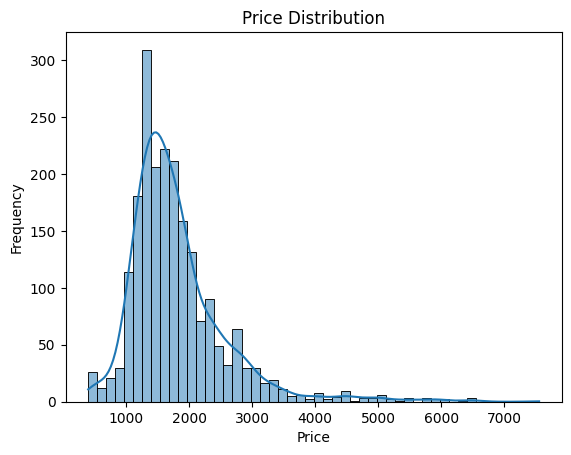

In [28]:
sns.histplot(df['price'], bins=50, kde=True)
plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

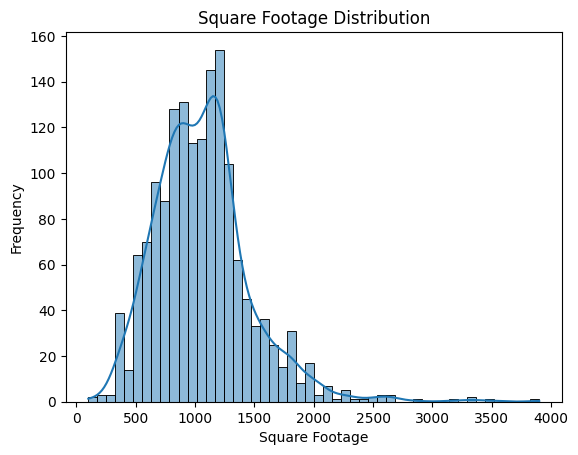

In [29]:
sns.histplot(df['square_footage'], bins=50, kde=True)
plt.title('Square Footage Distribution')
plt.xlabel('Square Footage')
plt.ylabel('Frequency')
plt.show()

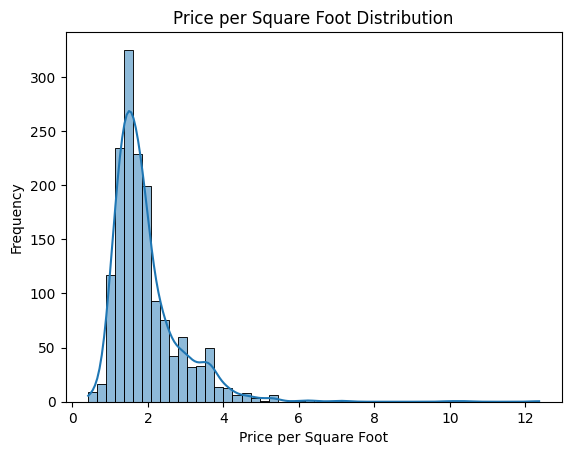

In [30]:
sns.histplot(df['price_per_sqft'], bins=50, kde=True)
plt.title('Price per Square Foot Distribution')
plt.xlabel('Price per Square Foot')
plt.ylabel('Frequency')
plt.show()

Text(0, 0.5, 'Frequency')

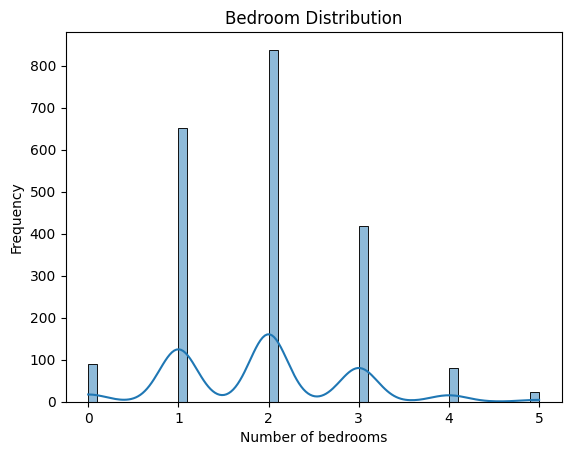

In [31]:
sns.histplot(df['bedrooms'], bins = 50, kde = True)
plt.title('Bedroom Distribution')
plt.xlabel('Number of bedrooms')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

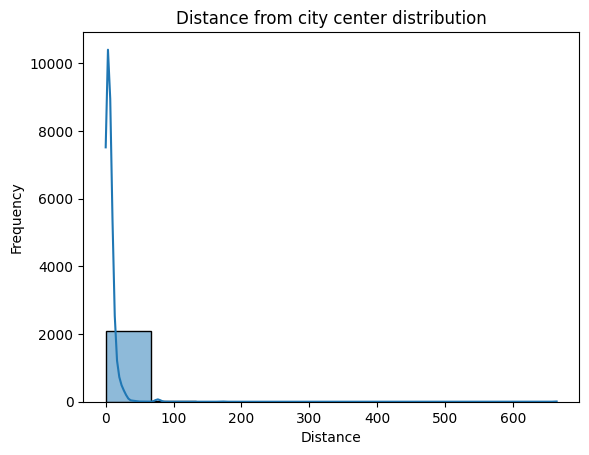

In [32]:
sns.histplot(df['distance_from_city_center'], bins = 10, kde=True)
plt.title('Distance from city center distribution')
plt.xlabel('Distance')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

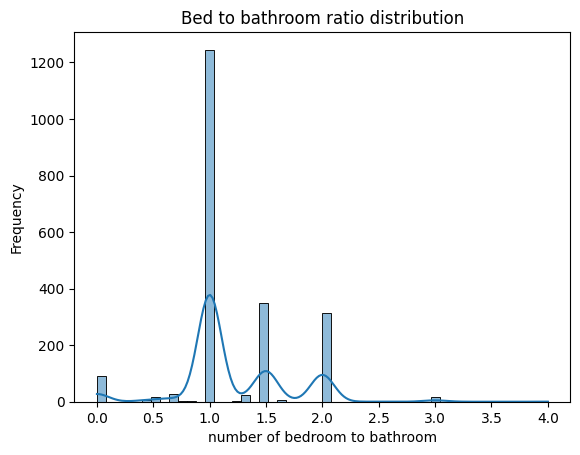

In [33]:
sns.histplot(df['bed_bath_ratio'], bins = 50, kde= True)
plt.title('Bed to bathroom ratio distribution')
plt.xlabel('number of bedroom to bathroom')
plt.ylabel('Frequency')

<Axes: xlabel='num_exclamations', ylabel='Count'>

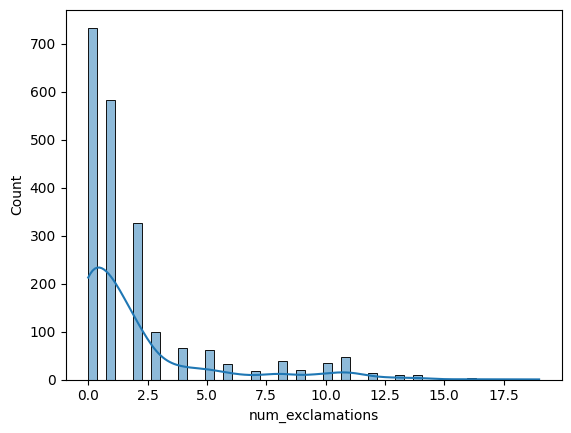

In [34]:
sns.histplot(df['num_exclamations'], bins = 50, kde=True)

<Axes: xlabel='num_all_caps', ylabel='Count'>

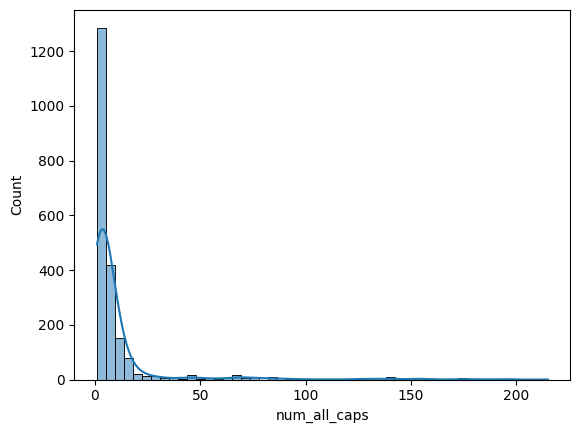

In [35]:
sns.histplot(df['num_all_caps'], bins = 50, kde=True)

<Axes: xlabel='num_scam_phrases', ylabel='Count'>

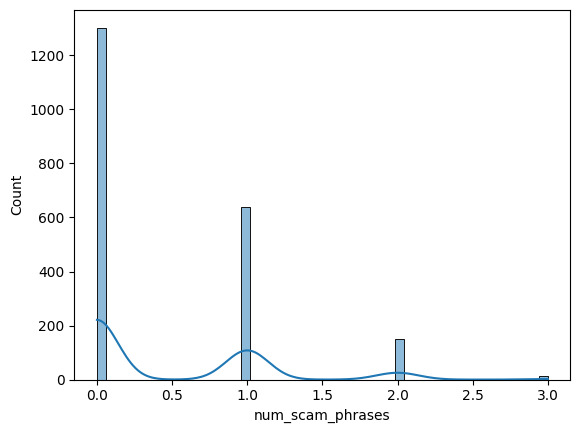

In [36]:
sns.histplot(df['num_scam_phrases'], bins = 50, kde=True)

<Axes: xlabel='desc_dup_count', ylabel='Count'>

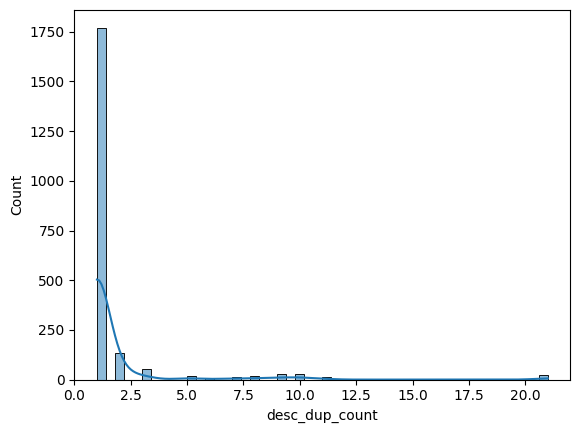

In [37]:
sns.histplot(df['desc_dup_count'], bins = 50, kde = True)

In [38]:
df['desc_dup_count'].unique()

array([ 6,  1,  2,  7,  3, 10,  5, 21,  9, 11,  8])

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2101 entries, 0 to 2114
Data columns (total 53 columns):
 #   Column                     Non-Null Count  Dtype              
---  ------                     --------------  -----              
 0   listing_id                 2101 non-null   object             
 1   source                     2101 non-null   category           
 2   listing_name               2101 non-null   object             
 3   price                      2101 non-null   float64            
 4   address                    2101 non-null   object             
 5   city                       2101 non-null   category           
 6   state                      2101 non-null   category           
 7   postal_code                2101 non-null   category           
 8   latitude                   2101 non-null   float64            
 9   longitude                  2101 non-null   float64            
 10  bedrooms                   2101 non-null   float64            
 11  bathrooms

In [40]:
categorical_cols = df.select_dtypes(include='category').columns

for col in categorical_cols:
    print(f"\n{col} value counts:")
    print(df[col].value_counts())



source value counts:
source
craigslist    2101
Name: count, dtype: int64

city value counts:
city
Sarasota       308
Orlando        164
Pensacola      149
Panama City    130
Miami          120
              ... 
Mount Dora       1
Plant City       1
Clearwater       1
Clarcona         1
Malabar          1
Name: count, Length: 121, dtype: int64

state value counts:
state
FL         2037
Unknown      64
Name: count, dtype: int64

postal_code value counts:
postal_code
32412      89
34243      68
Unknown    64
32514      62
34231      53
           ..
33434       1
32583       1
33445       1
33458       1
33185       1
Name: count, Length: 344, dtype: int64

post_weekday value counts:
post_weekday
Thursday     658
Wednesday    362
Monday       282
Tuesday      268
Friday       256
Saturday     146
Sunday       129
Name: count, dtype: int64


In [41]:
# drop risky or unhelpful features for unsupervised anomaly detection

# define feature groups to drop
drop_features = [
    # Identity / metadata
    'listing_id', 'url',
    
    # Redundant location info (used only for geo-processing, not modeling)
    'address', 'city', 'state', 'postal_code',
    'city_lat', 'city_lon',
    
    # Platform or data source bias
    'source',
    
    # Raw temporal metadata (too sparse or high-cardinality)
    'post_dayofweek', 'post_month', 'post_weekday', 'time_posted',
    
    # Linguistic booleans with low density and unclear impact
    'has_free', 'has_move_in', 'has_no_credit',
    'has_immediate', 'has_must_see',
    'has_act_now', 'has_cheap',

    # High cardinality text fields (unless you do NLP separately)
    'listing_name', 'description'
]

# Drop them from your DataFrame (assume df is your working DataFrame)
df_cleaned = df.drop(columns=[col for col in drop_features if col in df.columns])

print("Remaining features after pruning:")
print(df_cleaned.columns.tolist())


Remaining features after pruning:
['price', 'latitude', 'longitude', 'bedrooms', 'bathrooms', 'square_footage', 'address_missing', 'city_missing', 'state_missing', 'postal_code_missing', 'square_footage_missing', 'post_hour', 'posted_at_night', 'name_dup_count', 'has_contact_info', 'num_exclamations', 'num_all_caps', 'price_per_sqft', 'price_per_sqft_missing', 'bed_bath_ratio', 'location_cluster', 'location_is_noise', 'desc_dup_count', 'price_std_in_desc', 'sqft_std_in_desc', 'desc_mismatch_flag', 'desc_grouped', 'description_length', 'num_scam_phrases', 'scam_phrase_density', 'distance_from_city_center']


In [42]:
df_cleaned.head(3)

,price,latitude,longitude,bedrooms,bathrooms,square_footage,address_missing,city_missing,state_missing,postal_code_missing,square_footage_missing,post_hour,posted_at_night,name_dup_count,has_contact_info,num_exclamations,num_all_caps,price_per_sqft,price_per_sqft_missing,bed_bath_ratio,location_cluster,location_is_noise,desc_dup_count,price_std_in_desc,sqft_std_in_desc,desc_mismatch_flag,desc_grouped,description_length,num_scam_phrases,scam_phrase_density,distance_from_city_center
0,1950.0,26.556700,-81.903400,3.0,2.0,1330.0,False,False,False,False,False,17,False,1,False,1,2,1.466165,False,1.5,0,False,6,188.911355,200.4761,True,True,1209,0,0.0,6.422213
1,1625.0,26.556700,-81.903400,2.0,2.0,1202.0,False,False,False,False,False,16,False,1,False,1,2,1.351913,False,1.0,0,False,6,188.911355,200.4761,True,True,1209,0,0.0,6.422213
2,1449.0,26.570495,-81.835584,2.0,1.0,1050.0,False,False,False,False,False,17,False,2,False,2,4,1.380000,False,2.0,1,False,1,NaN,NaN,False,False,1577,0,0.0,1.557327


In [48]:
df_cleaned.shape

(2101, 31)

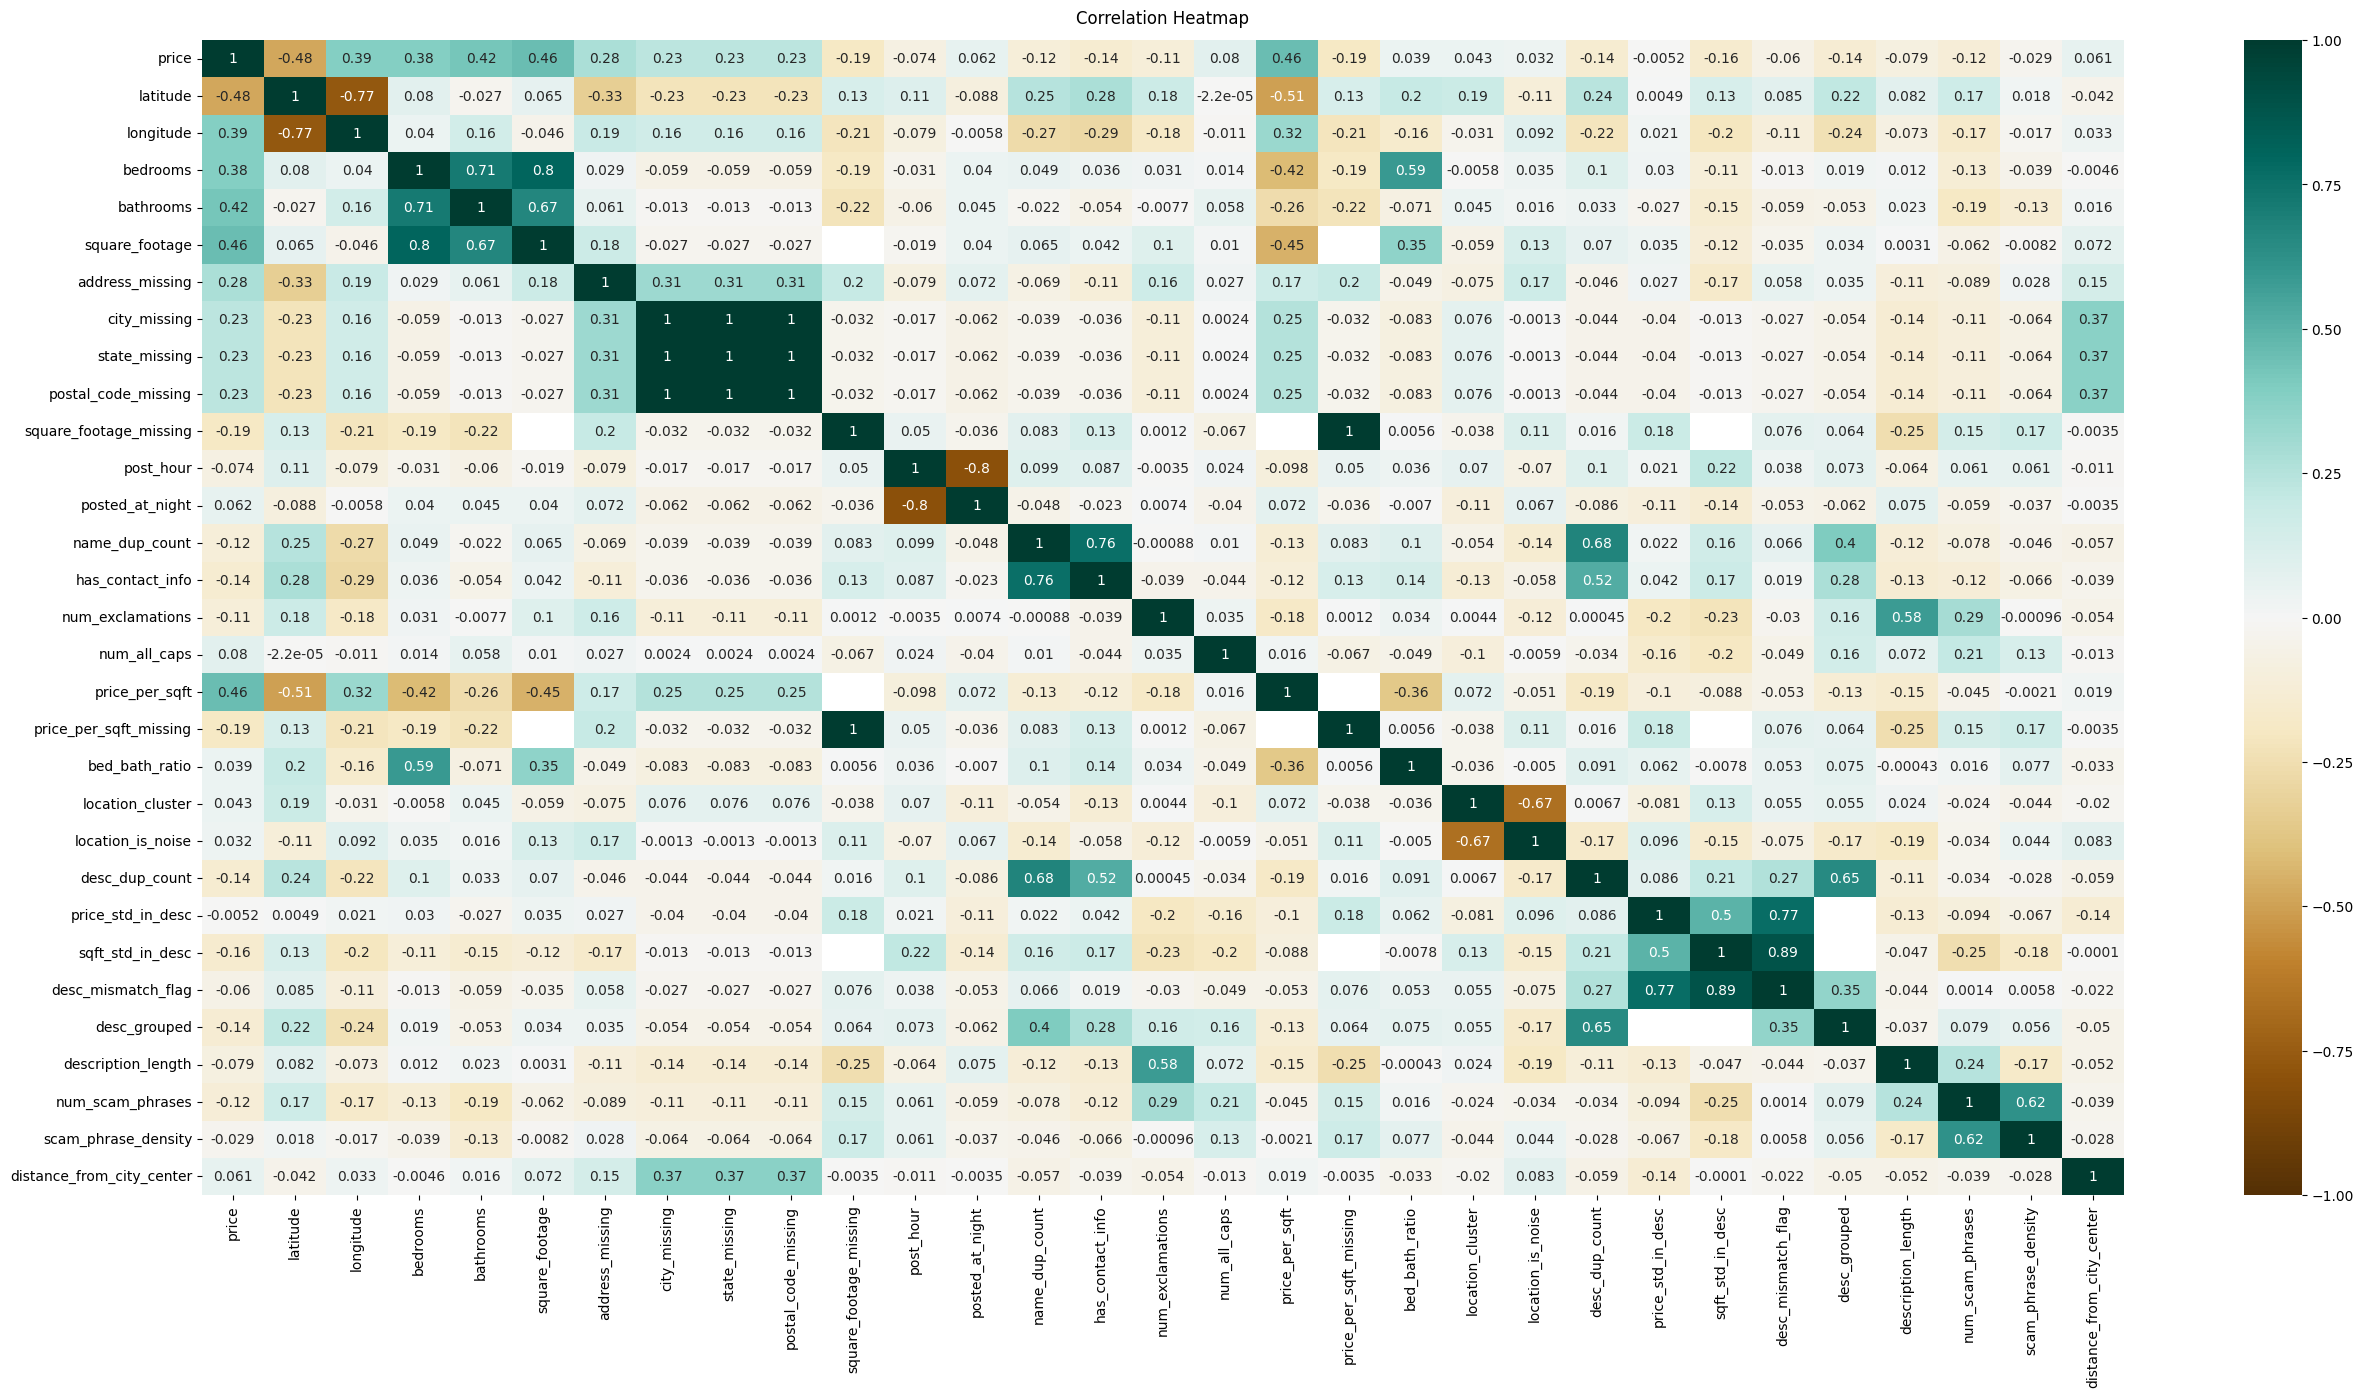

In [53]:
plt.figure(figsize=(31, 15))
heatmap = sns.heatmap(df_cleaned.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')

heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

In [ ]:
# Fill missing square_footage with median (or group by city if available)
df_cleaned['square_footage'] = df_cleaned['square_footage'].fillna(df_cleaned['square_footage'].median())

# Recalculate price_per_sqft after imputation
df_cleaned['price_per_sqft'] = df_cleaned['price'] / df_cleaned['square_footage']

df_cleaned = df_cleaned.drop(columns=[
    'price_std_in_desc', 'sqft_std_in_desc'  # optional if still NaN
])

In [65]:
from sklearn.ensemble import IsolationForest

iso_forest = IsolationForest(
    n_estimators=100,         # Number of trees
    contamination='auto',     # Automatically estimates the proportion of outliers
    random_state=42,          # For reproducibility
    verbose=0
)

In [104]:
iso_forest.fit(df_cleaned)
df_cleaned['if_label'] = iso_forest.predict(df_cleaned)
df_cleaned['anomaly_score'] = iso_forest.decision_function(df_cleaned)
top_outliers = df_cleaned.sort_values(by='anomaly_score')


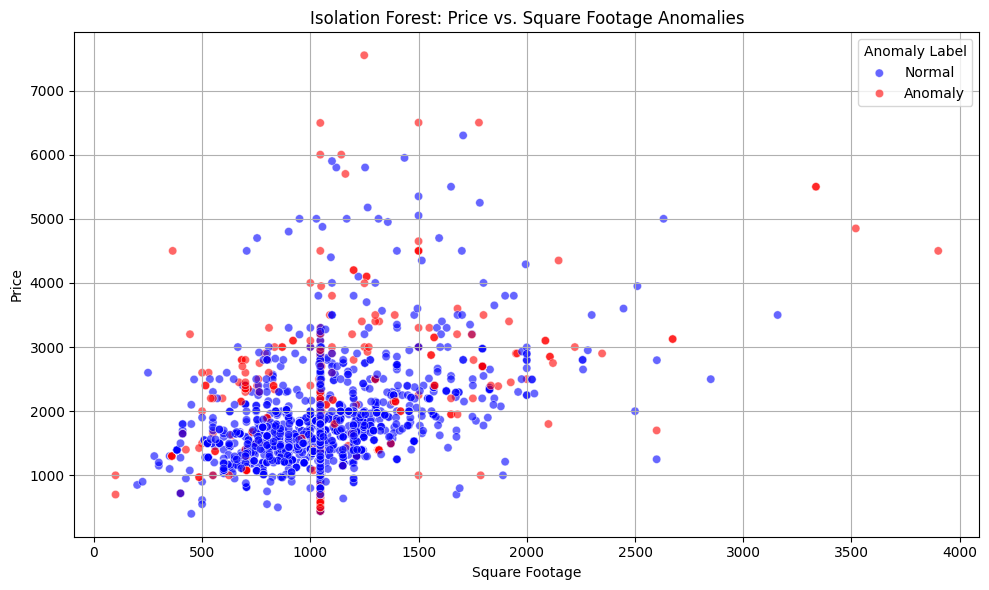

In [105]:
# Scatterplot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_cleaned,
    x='square_footage',
    y='price',
    hue='if_label',
    palette={1: 'blue', -1: 'red'},
    alpha=0.6
)
plt.title("Isolation Forest: Price vs. Square Footage Anomalies")
plt.xlabel("Square Footage")
plt.ylabel("Price")
plt.legend(title="Anomaly Label", labels=["Normal", "Anomaly"])
plt.grid(True)
plt.tight_layout()
plt.show()

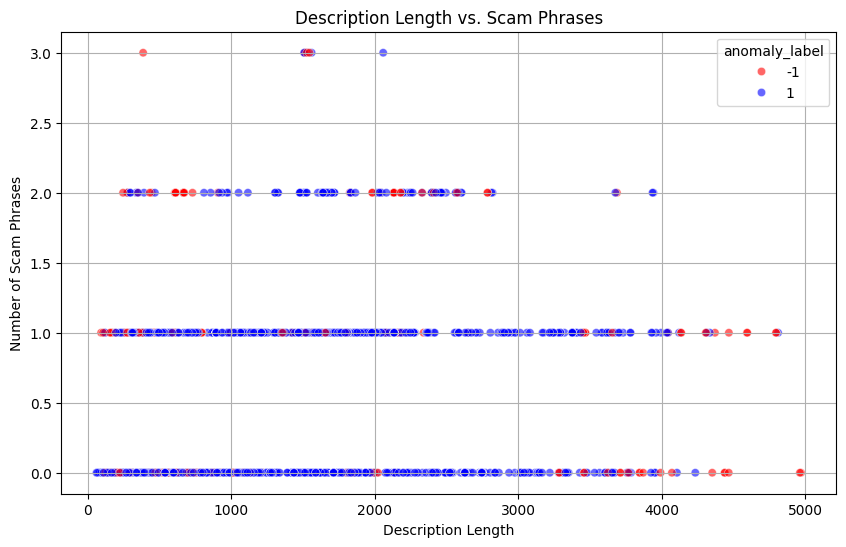

In [106]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_cleaned, x='description_length', y='num_scam_phrases',
                hue='anomaly_label', palette={1: 'blue', -1: 'red'}, alpha=0.6)
plt.title("Description Length vs. Scam Phrases")
plt.xlabel("Description Length")
plt.ylabel("Number of Scam Phrases")
plt.grid(True)
plt.show()

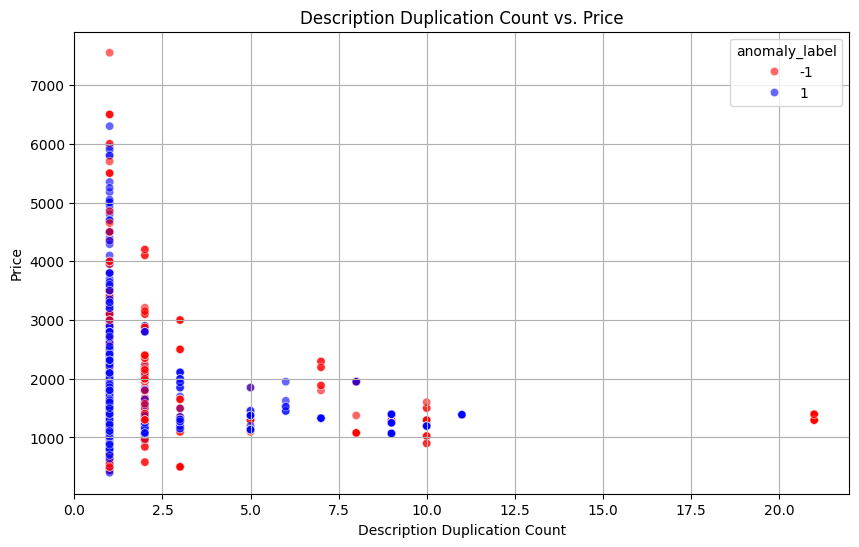

In [74]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_cleaned, x='desc_dup_count', y='price',
                hue='anomaly_label', palette={1: 'blue', -1: 'red'}, alpha=0.6)
plt.title("Description Duplication Count vs. Price")
plt.xlabel("Description Duplication Count")
plt.ylabel("Price")
plt.grid(True)
plt.show()


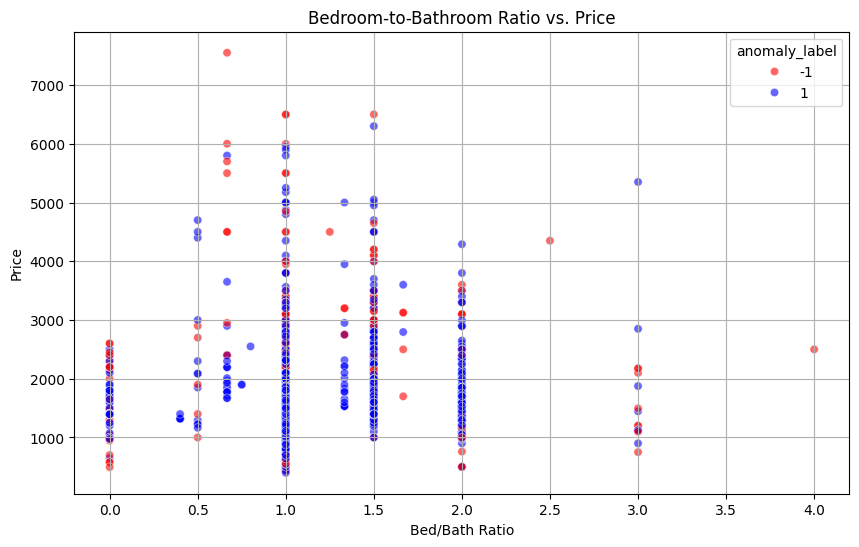

In [107]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_cleaned, x='bed_bath_ratio', y='price',
                hue='anomaly_label', palette={1: 'blue', -1: 'red'}, alpha=0.6)
plt.title("Bedroom-to-Bathroom Ratio vs. Price")
plt.xlabel("Bed/Bath Ratio")
plt.ylabel("Price")
plt.grid(True)
plt.show()


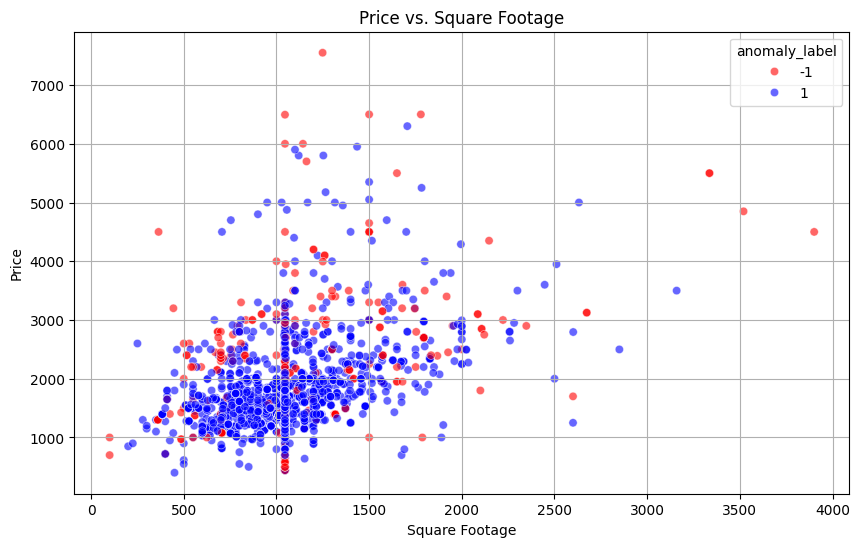

In [77]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_cleaned, x='square_footage', y='price',
                hue='anomaly_label', palette={1: 'blue', -1: 'red'}, alpha=0.6)
plt.title("Price vs. Square Footage")
plt.xlabel("Square Footage")
plt.ylabel("Price")
plt.grid(True)
plt.show()


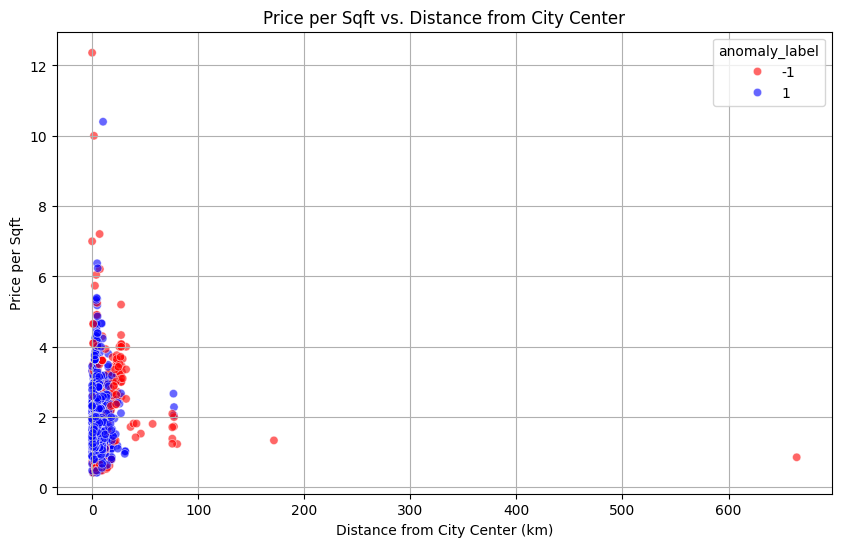

In [78]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_cleaned, x='distance_from_city_center', y='price_per_sqft',
                hue='anomaly_label', palette={1: 'blue', -1: 'red'}, alpha=0.6)
plt.title("Price per Sqft vs. Distance from City Center")
plt.xlabel("Distance from City Center (km)")
plt.ylabel("Price per Sqft")
plt.grid(True)
plt.show()


In [79]:
features = [
    'price', 'latitude', 'longitude', 'bedrooms', 'bathrooms',
    'square_footage', 'post_hour', 'posted_at_night', 'name_dup_count',
    'has_contact_info', 'num_exclamations', 'num_all_caps',
    'price_per_sqft', 'location_cluster', 'location_is_noise',
    'desc_dup_count', 'desc_mismatch_flag', 'desc_grouped',
    'description_length', 'num_scam_phrases', 'scam_phrase_density',
    'distance_from_city_center', 'bed_bath_ratio'
]

X_dbscan = df_cleaned[features].copy()


In [80]:
X_dbscan = X_dbscan.dropna()  # safest option for now


In [81]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_dbscan)

In [114]:
from sklearn.cluster import DBSCAN

# Initialize DBSCAN
dbscan = DBSCAN(
    eps=2.5,           # Distance threshold (try tuning later)
    min_samples=10     # Minimum neighbors to form a cluster
)

# Fit and predict
dbscan_labels = dbscan.fit_predict(X_scaled)

# Add results to your original dataframe (make sure it's aligned!)
df_dbscan = X_dbscan.copy()
df_dbscan['dbscan_label'] = dbscan_labels
df_cleaned['dbscan_label'] = dbscan_labels


In [102]:
# Count clusters and outliers
label_counts = df_dbscan['dbscan_label'].value_counts()

# Show how many were flagged as anomalies
print("DBSCAN Label Counts:\n", label_counts)


DBSCAN Label Counts:
 dbscan_label
 0     1254
-1      461
 1      120
 13      46
 7       39
 2       29
 5       21
 14      21
 3       19
 9       17
 4       16
 12      15
 8       12
 10      11
 6       10
 11      10
Name: count, dtype: int64


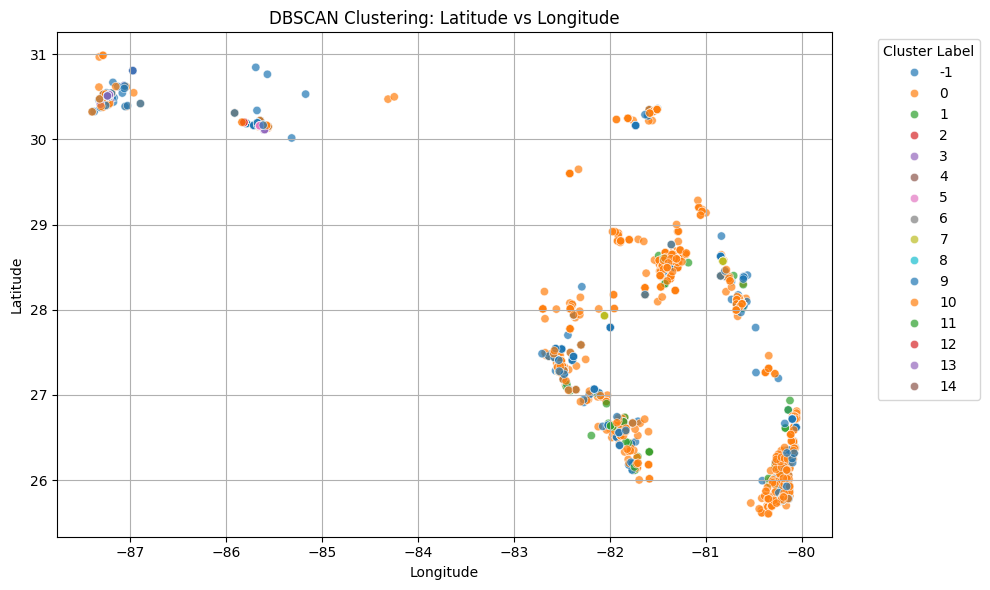

In [95]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_dbscan,
    x='longitude', y='latitude',
    hue='dbscan_label',
    palette='tab10',
    legend='full',
    alpha=0.7
)
plt.title("DBSCAN Clustering: Latitude vs Longitude")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.legend(title="Cluster Label", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


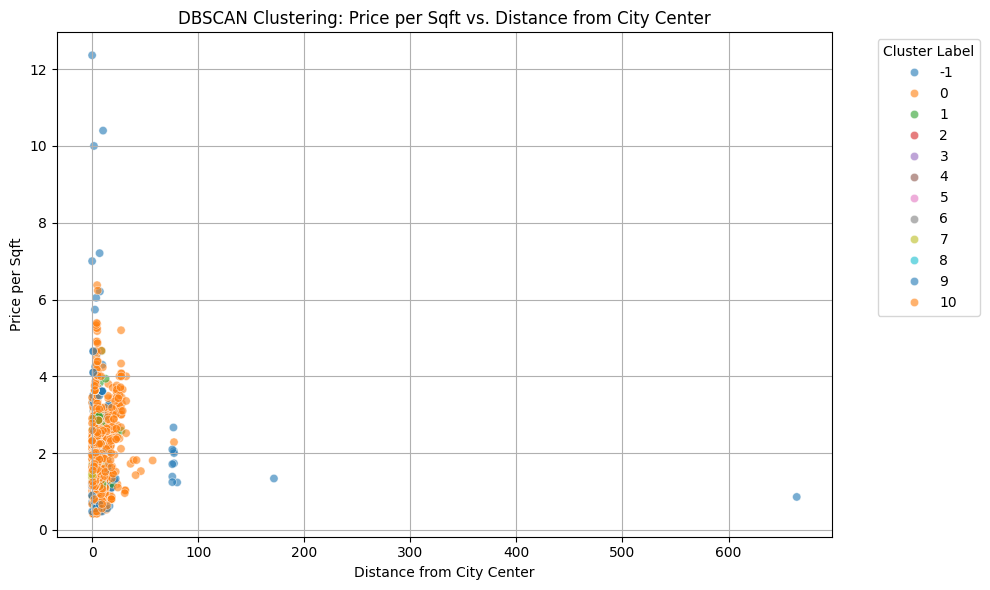

In [92]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_dbscan,
    x='distance_from_city_center',
    y='price_per_sqft',
    hue='dbscan_label',
    palette='tab10',
    alpha=0.6
)
plt.title("DBSCAN Clustering: Price per Sqft vs. Distance from City Center")
plt.xlabel("Distance from City Center")
plt.ylabel("Price per Sqft")
plt.grid(True)
plt.legend(title="Cluster Label", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [108]:
from sklearn.neighbors import LocalOutlierFactor

# Initialize LOF
lof = LocalOutlierFactor(
    n_neighbors=20,   # Number of neighbors to compare density to
    contamination=0.1,  # Proportion of anomalies you expect (tune this)
    novelty=False      # Must be False for unsupervised outlier detection
)

# Fit and predict on scaled data
lof_labels = lof.fit_predict(X_scaled)  # -1 = outlier, 1 = inlier
lof_scores = -lof.negative_outlier_factor_  # Higher = more anomalous

# Add to DataFrame
df_cleaned['lof_label'] = lof_labels
df_cleaned['lof_score'] = lof_scores


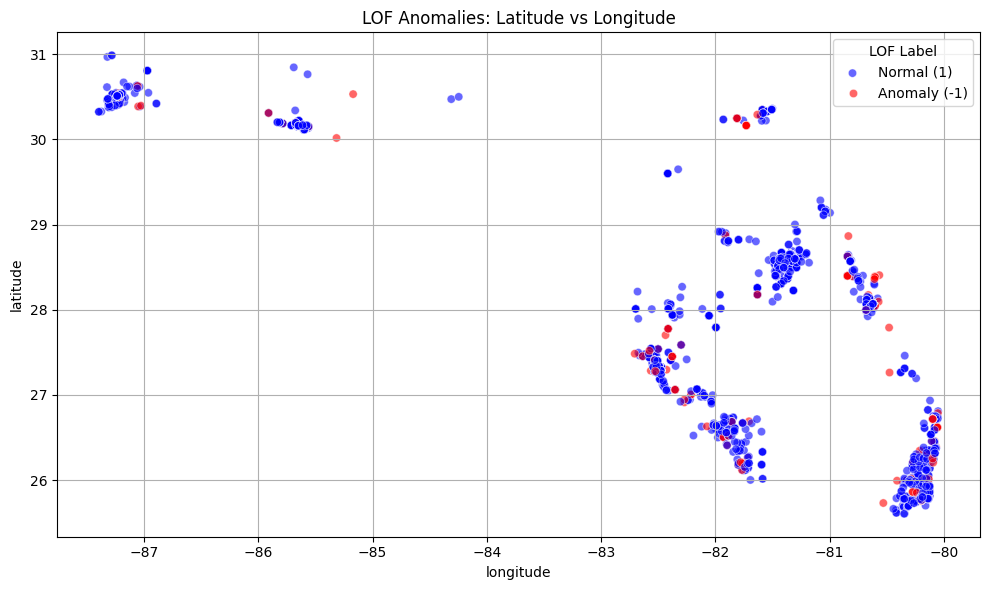

In [109]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='longitude', y='latitude',
    data=df_cleaned,
    hue='lof_label',
    palette={1: 'blue', -1: 'red'},
    alpha=0.6
)
plt.title("LOF Anomalies: Latitude vs Longitude")
plt.legend(title='LOF Label', labels=['Normal (1)', 'Anomaly (-1)'])
plt.grid(True)
plt.tight_layout()
plt.show()




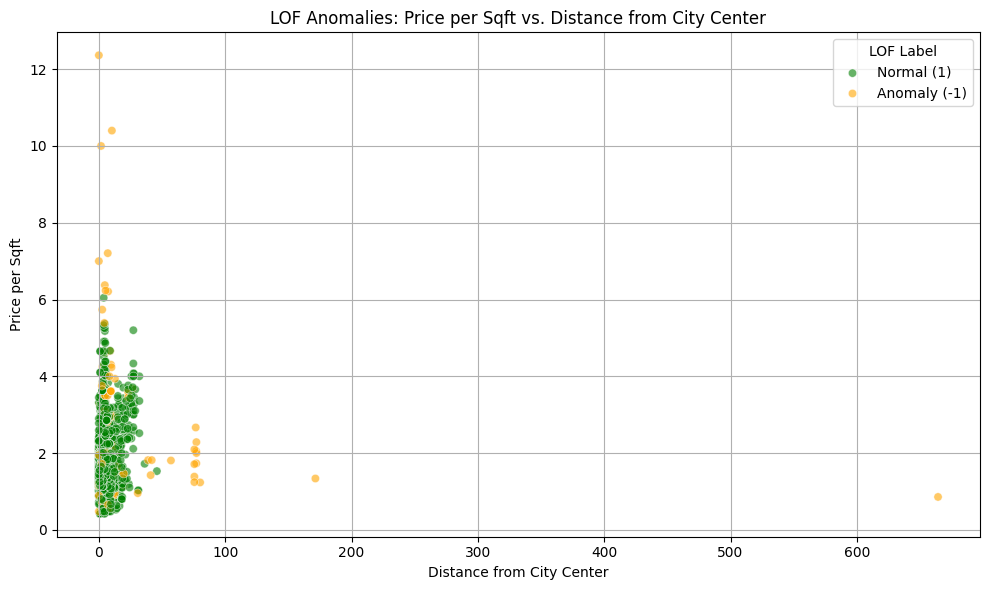

In [110]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_cleaned,
    x='distance_from_city_center',
    y='price_per_sqft',
    hue='lof_label',
    palette={1: 'green', -1: 'orange'},
    alpha=0.6
)
plt.title("LOF Anomalies: Price per Sqft vs. Distance from City Center")
plt.xlabel("Distance from City Center")
plt.ylabel("Price per Sqft")
plt.grid(True)
plt.legend(title='LOF Label', labels=['Normal (1)', 'Anomaly (-1)'])
plt.tight_layout()
plt.show()



In [115]:
df_cleaned['is_if_outlier'] = df_cleaned['if_label'] == -1
df_cleaned['is_dbscan_outlier'] = df_cleaned['dbscan_label'] == -1
df_cleaned['is_lof_outlier'] = df_cleaned['lof_label'] == -1



In [116]:
df_cleaned['outlier_any_model'] = (
    df_cleaned['is_if_outlier'] |
    df_cleaned['is_dbscan_outlier'] |
    df_cleaned['is_lof_outlier']
)



In [117]:
df_cleaned['outlier_all_models'] = (
    df_cleaned['is_if_outlier'] &
    df_cleaned['is_dbscan_outlier'] &
    df_cleaned['is_lof_outlier']
)


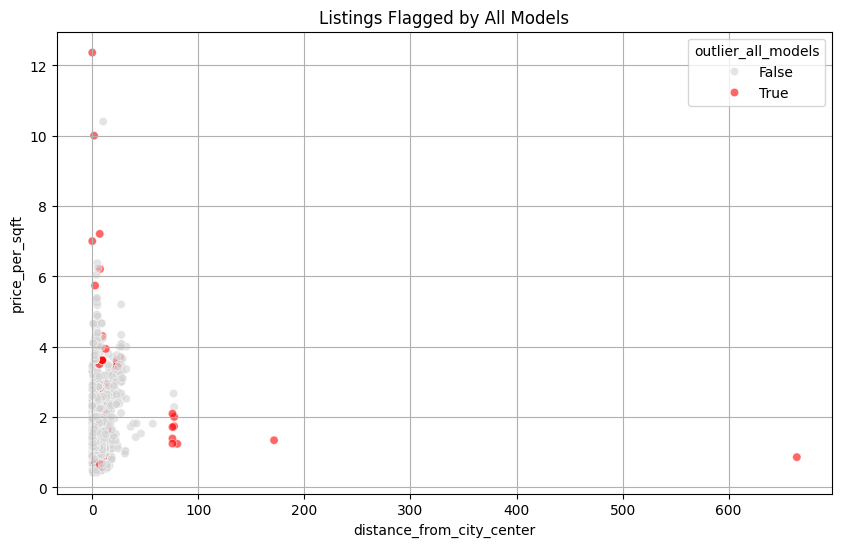

In [118]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_cleaned,
    x='distance_from_city_center', y='price_per_sqft',
    hue='outlier_all_models',
    palette={False: 'lightgray', True: 'red'},
    alpha=0.6
)
plt.title("Listings Flagged by All Models")
plt.grid(True)
plt.show()

